#  Predicting Stock Yields using NLP

Deep learning NLP techniques to map raw text to dense vector representations have had some surprising success in the world of computer natural language processing compared to classical means of encoding text. In this project we will attempt to leverage some of these techniques to help assist us in time series analysis on stock yields. The company we will choose to investigate is Wells Fargo (stock ticker: WFC), and the text data we will be leveraging are the SEC forms of Wells Fargo along with its competitors: JPMorgan Chase, Bank of America, and Citigroup. Specifically the 8-K form. The 8-K form was chosen because it tends to be the more text rich SEC document when compared to others.

In [1]:
# Setting notebook global variables

import os
import sys
import numpy as np

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
# Company Stock Ticker and CIK number
ticker = 'WFC'
competitors = ['JPM', 'BAC', 'C']
tickers = [ticker] + competitors

## Fetching Data

For this project we will need two data sources. Firstly we will need access to Wells Fargo's historical stock price data. We will use an API to access this data (since it will be much easier than webscraping it). This gives us two options: Quandl's end of day stock price data API, or Alphavantage's end of day stock price, adjusted time series API. Since Quandl's API costs money we will use Alphavantage's API since its free. The second data source we need is access to Wells Fargo's published 8-K forms. For this data source we will web scrape the SEC's database: EDGAR, to gather the necessary data.

### Fetching Stock Price Data

Fetching end of day stock price data from alphavantage: https://www.alphavantage.co/ using fetch_stock_data. Then checking the returned DataFrame object to confirm that the end of day stock price data was successfully loaded into the object.

In [2]:
# Importing Libraries

import os
import io
import json
import requests
import pandas as pd

def get_api_key(source):
    '''
    STILL NEEDS WORK, want to keep same API, but don't know how to link to area where user api keys are stored.
    
    Returns api key for the specific source, :param source:.
    
    :param source: string, name of api source
    
    ---> String, api key for the the specific source :param source:
    '''
    
    path_to_keys = os.path.join(project_dir, 'api_keys.json')
    with open(path_to_keys, 'r') as f:
        api_keys = json.load(f)
    
    return api_keys[source]


def fetch_stock_data(ticker, start_date, end_date=None, source='alphavantage'):
    '''
    Returns end of day stock price DataFrame from various sources.
    
    :param ticker: string, stock ticker
    :param start_date: string, date to start collecting data after, format: YYYY-MM-DD
    :param end_date: string, date to end collecting data at, format: YYYY-MM-DD
    :param source: string 'alphavantage' or 'quandl', specifies the source of the data
    
    ---> DataFrame, of end of day stock price data
    '''
    
    # endpoints for each data source
    source_urls = {'alphavantage': 'https://www.alphavantage.co/query',
                   'quandl': 'https://www.quandl.com/api/v3/datasets/EOD/'}
    
    # API parameters for each data source
    source_params = {'alphavantage': {'function': 'TIME_SERIES_DAILY_ADJUSTED',
                                      'symbol': ticker, 'datatype': 'csv', 'apikey': get_api_key(source),
                                      'outputsize': 'full'},
                     'quandl': {'api_key': get_api_key(source)}}

    # Setting endpoints
    url = source_urls[source]
    if source == 'quandl':
        url = url + ticker + '.csv'
    
    # Settings API parameters
    params = source_params[source]
    
    # Requesting API
    response = requests.get(url, params=params)
    
    # Creating DataFrame
    if source == 'alphavantage':
        date_col = 'timestamp'
    elif source == 'quandl':
        date_col = 'date'    
    df = pd.read_csv(io.StringIO(response.text), parse_dates=[date_col])
    
    # Slicing DataFrame
    if start_date != None:
        df = df.loc[df[date_col] > start_date]
    if end_date != None:
        df = df.loc[df[date_col] <= end_date]
    
    return df

Generating end of day stock price DataFrame.

In [3]:
price_df = fetch_stock_data(ticker, start_date=None)

Checking DataFrame info.

In [4]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 9 columns):
timestamp            5033 non-null datetime64[ns]
open                 5033 non-null float64
high                 5033 non-null float64
low                  5033 non-null float64
close                5033 non-null float64
adjusted_close       5033 non-null float64
volume               5033 non-null int64
dividend_amount      5033 non-null float64
split_coefficient    5033 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 354.0 KB


Checking the first five rows and the last five rows of DataFrame.

In [5]:
price_df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2019-10-11,49.46,49.92,49.15,49.21,49.21,22763506,0.0,1.0
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800,0.0,1.0
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800,0.0,1.0
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000,0.0,1.0
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900,0.0,1.0


In [6]:
price_df.tail()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
5028,1999-10-18,19.4690,19.844,19.2507,19.750,11.4299,5041000,0.0,1.0
5029,1999-10-15,19.3749,19.938,19.2190,19.500,11.2853,7528400,0.0,1.0
5030,1999-10-14,19.8133,20.406,19.7810,20.281,11.7374,6496800,0.0,1.0
5031,1999-10-13,20.7190,20.938,19.4690,19.844,11.4842,4730400,0.0,1.0
5032,1999-10-12,21.0000,21.000,20.6560,20.844,12.0629,3970600,0.0,1.0


Looks like everything works out!

### Fetching Text Data

Fetching Wells Fargo's, and its competitors' 8-K forms from the SEC database. (Link to SEC database, EDGAR: https://www.sec.gov/edgar/searchedgar/companysearch.html) The scraped 8-K forms are saved to the documents folder which lies in the data folder inside a company specific folder labeled by stock ticker, and are saved in raw text file format. A DataFrame is returned for each company where each row consists of a filing date, and a path to where the 8-K form is saved.

In [7]:
# Importing Libraries

import re
import lxml
import pandas as pd
from datetime import date
from functools import reduce
from bs4 import BeautifulSoup


def generate_url_df(cik, start_date, end_date=None, form_type='8-k'):
    '''
    Returns a DataFrame  where each row consists of a forms filing date, and an url to the raw text version
    of the form.
    
    :param cik: string, the SEC CIK number for the specific company or stock ticker symbol
    :param start_date: string, date to start collecting data after, format: YYYY-MM-DD
    :param end_date: string, date to end collecting data at, format: YYYY-MM-DD
    :param form_type: string '8-k', '10-k', ..., the type of SEC form to search for
    
    ---> DataFrame, of filing dates and urls to raw text versions of the specified form
    '''
    
    edgar_url = 'https://www.sec.gov/cgi-bin/browse-edgar'
    
    edgar_params = {'action': 'getcompany', 'CIK': cik, 'type': form_type,
                    'owner': 'exclude', 'count': '100', 'output': 'atom', 'start': ''}
    
    edgar_response = requests.get(edgar_url, params=edgar_params)
    
    soup = BeautifulSoup(edgar_response.text, 'lxml')
    
    all_docs = []
    # While the link to the next page existing is true
    while True:
        # Find all document entries on the page
        entries = soup.find_all('entry')
        # For each entry
        for entry in entries:
            # scrape the entry's filing date
            filing_date = entry.find('filing-date').text
            # Add entry url to list if its filing date meets certain requirements, CAN REFACTOR this section
            if (start_date == None) and (end_date == None):
                doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                doc_entry = (filing_date, doc_link)
                all_docs.append(doc_entry)
            elif (start_date == None) and (end_date != None):
                if date.fromisoformat(filing_date) <= date.fromisoformat(end_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
            elif (start_date != None) and (end_date == None):
                if date.fromisoformat(filing_date) >= date.fromisoformat(start_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
            else:
                if date.fromisoformat(start_date) <= date.fromisoformat(filing_date) <= date.fromisoformat(end_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
        # Break loop after scraping entries on the current page, but before requesting on the link to the next page which is potentially none existant
        if soup.find_all('link', {'rel': 'next'}) == []:
            break
        # Find link to the next page, request next page, and update soup object to consist of the next page
        nxt_pg_link = soup.find_all('link', {'rel': 'next'})[0]['href']
        nxt_pg = requests.get(nxt_pg_link)
        soup = BeautifulSoup(nxt_pg.text, 'lxml')
    # Creating DataFrame
    doc_df = pd.DataFrame(all_docs, columns=['filing_date', 'doc_loc'])
    doc_df['filing_date'] = pd.to_datetime(doc_df['filing_date'])
    
    return doc_df

Generating url DataFrames.

In [8]:
doc_dfs = {}
for t in [ticker] + competitors:
    doc_df_t = generate_url_df(t, start_date=None)
    doc_dfs[t] = doc_df_t

Checking info of each DataFrame.

In [9]:
for t in doc_dfs.keys():
    print(t)
    doc_dfs[t].info()
    print()

WFC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 2 columns):
filing_date    1246 non-null datetime64[ns]
doc_loc        1246 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 19.6+ KB

JPM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 2 columns):
filing_date    1176 non-null datetime64[ns]
doc_loc        1176 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 18.5+ KB

BAC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
filing_date    541 non-null datetime64[ns]
doc_loc        541 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 8.6+ KB

C
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 2 columns):
filing_date    829 non-null datetime64[ns]
doc_loc        829 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 13.1+ KB



Checking the first five, and last five rows of each DataFrame

In [10]:
# First 5 Rows
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].head())
    print()

WFC
  filing_date                                            doc_loc
0  2019-10-11  https://www.sec.gov/Archives/edgar/data/72971/...
1  2019-10-08  https://www.sec.gov/Archives/edgar/data/72971/...
2  2019-10-04  https://www.sec.gov/Archives/edgar/data/72971/...
3  2019-10-03  https://www.sec.gov/Archives/edgar/data/72971/...
4  2019-10-02  https://www.sec.gov/Archives/edgar/data/72971/...

JPM
  filing_date                                            doc_loc
0  2019-09-26  https://www.sec.gov/Archives/edgar/data/19617/...
1  2019-09-12  https://www.sec.gov/Archives/edgar/data/19617/...
2  2019-08-20  https://www.sec.gov/Archives/edgar/data/19617/...
3  2019-08-02  https://www.sec.gov/Archives/edgar/data/19617/...
4  2019-07-31  https://www.sec.gov/Archives/edgar/data/19617/...

BAC
  filing_date                                            doc_loc
0  2019-09-17  https://www.sec.gov/Archives/edgar/data/70858/...
1  2019-09-16  https://www.sec.gov/Archives/edgar/data/70858/...
2  2019-09-

In [11]:
# Last 5 Rows
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].tail())
    print()

WFC
     filing_date                                            doc_loc
1241  1995-01-09  https://www.sec.gov/Archives/edgar/data/72971/...
1242  1994-11-15  https://www.sec.gov/Archives/edgar/data/72971/...
1243  1994-11-01  https://www.sec.gov/Archives/edgar/data/72971/...
1244  1994-07-21  https://www.sec.gov/Archives/edgar/data/72971/...
1245  1994-02-15  https://www.sec.gov/Archives/edgar/data/72971/...

JPM
     filing_date                                            doc_loc
1171  1994-07-07  https://www.sec.gov/Archives/edgar/data/19617/...
1172  1994-06-20  https://www.sec.gov/Archives/edgar/data/19617/...
1173  1994-06-01  https://www.sec.gov/Archives/edgar/data/19617/...
1174  1994-04-20  https://www.sec.gov/Archives/edgar/data/19617/...
1175  1994-01-21  https://www.sec.gov/Archives/edgar/data/19617/...

BAC
    filing_date                                            doc_loc
536  1995-01-26  https://www.sec.gov/Archives/edgar/data/70858/...
537  1994-12-22  https://www.sec.gov

### Saving Data to Disk

After generating both the end of day stock price DataFrame, and the 8-K url DataFrames, we first save the 8-K documents to disk locally while updating the links to the 8-K forms in the corresponding DataFrames. Next we merge all the document DataFrames into one document DataFrame with two columns: filing_data, and doc_loc, where doc_loc now contains lists of document paths that were released on the same date. These two DataFrames, the merged document DataFrame, and the stock price DataFrame, are merged into a DataFrame that contains both sources of data and will represent our full dataset. Each row in this DataFrame contains a date, and the corresponding end of day stock price data, along with a list of paths to the 8-K documents that were released on the corresponding date. This DataFrame is then cleaned and saved locally as a csv file.

In [12]:
# Importing Libraries

import os
import json
import requests

def save_doc(url, endpoint):
    '''
    Downloads and saves the text file stored at :param url:, and saves it as its downloaded name in directory
    :param endpoint:.
    
    :param url: String, the url that points to the SEC text file
    :parame endpoint: String, path to location to save SEC filing
    
    ---> String, path to saved document
    '''
    
    if not os.path.isdir(endpoint):
        os.mkdir(endpoint)
    try:
        r = requests.get(url)
    except Exception as e:
        raise Exception('error with url: {}'.format(url)) from e
        
    fname = url.split('/')[-1]
    with open(os.path.join(endpoint, fname), 'wb') as f:
        f.write(r.content)
    return os.path.join(endpoint, fname)

Saving the 8-K forms to disk in the documents folder located in the data folder. Updating the doc_loc column of each document DataFrame to reflect the local location of where the 8-K documents were saved to.

In [13]:
for t in doc_dfs.keys():
    print('saving: {}'.format(t))
    doc_dfs[t]['doc_loc'] = doc_dfs[t]['doc_loc'].map(lambda url: save_doc(url, os.path.join(path_to_docs, t)) if not pd.isnull(url) else np.nan)

saving: WFC
saving: JPM
saving: BAC
saving: C


Checking if the document DataFrames of each ticker were updated properly by viewing their first 10 rows.

In [61]:
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].head())
    print()

WFC
  filing_date                                                doc
0  2019-10-11  {"link": "/media/Data/Programs/FinTech/data/do...
1  2019-10-08  {"link": "/media/Data/Programs/FinTech/data/do...
2  2019-10-04  {"link": "/media/Data/Programs/FinTech/data/do...
3  2019-10-03  {"link": "/media/Data/Programs/FinTech/data/do...
4  2019-10-02  {"link": "/media/Data/Programs/FinTech/data/do...

JPM
  filing_date                                                doc
0  2019-09-26  {"link": "/media/Data/Programs/FinTech/data/do...
1  2019-09-12  {"link": "/media/Data/Programs/FinTech/data/do...
2  2019-08-20  {"link": "/media/Data/Programs/FinTech/data/do...
3  2019-08-02  {"link": "/media/Data/Programs/FinTech/data/do...
4  2019-07-31  {"link": "/media/Data/Programs/FinTech/data/do...

BAC
  filing_date                                                doc
0  2019-09-17  {"link": "/media/Data/Programs/FinTech/data/do...
1  2019-09-16  {"link": "/media/Data/Programs/FinTech/data/do...
2  2019-09-

In [15]:
# Saving doc_dfs to disk

for t in doc_dfs.keys():
    print('saving: {}'.format(t))
    tdf = doc_dfs[t]
    path_to_doc_dfs = os.path.join(path_to_data, 'doc_dfs')
    tdf.to_csv(os.path.join(path_to_doc_dfs, 'doc_' + t + '.csv'), index=False)

saving: WFC
saving: JPM
saving: BAC
saving: C


Merging all document DataFrames into one document DataFrame with two columns: filing_data, and doc, where doc contains a list of documents (dictionaries) that were released on the same date. Each document contains keys: link (link to the location of the document), and ticker (ticker for the company that filed the document).

In [16]:
# Creating document dictionaries

# helper function
def link_to_dict(link, ticker):
    return json.dumps({'link': link, 'ticker': ticker})

for t in doc_dfs.keys():
    doc_dfs[t]['doc_loc'] = doc_dfs[t]['doc_loc'].map(lambda link: link_to_dict(link, t))
    doc_dfs[t].columns = ['filing_date', 'doc']

In [17]:
'''
Concatenating DataFrames along axis 0, grouping by same filing_date,
and applying the list constructor to the doc_loc panda Series of each group.
We then reset the index of the returned Series to generate a pandas DataFrame with
the index (filing_date) and doc_loc as columns. We finally sort the final DataFrame
by the filing_date column.
'''

def series_to_jsonlist(series):
    json_list = []
    for json_str in series:
        python_dict = json.loads(json_str)
        json_list.append(python_dict)
    return json.dumps(json_list)
        
    
doc_df = pd.concat(doc_dfs.values(), axis=0).groupby('filing_date')['doc'].apply(series_to_jsonlist).reset_index().sort_values(by='filing_date', ascending=False)

Checking the info of our merged documents DataFrame.

In [18]:
doc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2625 entries, 2624 to 0
Data columns (total 2 columns):
filing_date    2625 non-null datetime64[ns]
doc            2625 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 61.5+ KB


Checking the first five, and last five rows of the merged document DataFrame

In [19]:
doc_df.head()

,filing_date,doc
2624,2019-10-11,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
2623,2019-10-08,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
2622,2019-10-04,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
2621,2019-10-03,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
2620,2019-10-02,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."


In [20]:
doc_df.tail()

,filing_date,doc
4,1994-03-01,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
3,1994-02-15,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
2,1994-01-26,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
1,1994-01-21,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
0,1994-01-13,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."


Merging the end of day stock price DataFrame, and 8-K document DataFrame on their respective date columns.

In [21]:
df = price_df.merge(doc_df, how='outer', left_on='timestamp', right_on='filing_date')

Checking if dataframes were merged properly.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5253 entries, 0 to 5252
Data columns (total 11 columns):
timestamp            5033 non-null datetime64[ns]
open                 5033 non-null float64
high                 5033 non-null float64
low                  5033 non-null float64
close                5033 non-null float64
adjusted_close       5033 non-null float64
volume               5033 non-null float64
dividend_amount      5033 non-null float64
split_coefficient    5033 non-null float64
filing_date          2625 non-null datetime64[ns]
doc                  2625 non-null object
dtypes: datetime64[ns](2), float64(8), object(1)
memory usage: 492.5+ KB


Checking the first 20 rows and the last 20 rows of the merged DataFrame

In [23]:
df.head(20)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc
0,2019-10-11,49.46,49.92,49.15,49.21,49.21,22763506.0,0.0,1.0,2019-10-11,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,NaT,NaN
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,NaT,NaN
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,2019-10-08,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900.0,0.0,1.0,NaT,NaN
5,2019-10-04,48.66,49.25,48.53,49.21,49.21,15779500.0,0.0,1.0,2019-10-04,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
6,2019-10-03,48.30,48.51,47.32,48.48,48.48,20212200.0,0.0,1.0,2019-10-03,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
7,2019-10-02,48.72,49.04,48.37,48.47,48.47,23515900.0,0.0,1.0,2019-10-02,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
8,2019-10-01,50.65,50.78,49.00,49.06,49.06,27249300.0,0.0,1.0,NaT,NaN
9,2019-09-30,50.77,50.85,50.06,50.44,50.44,26897100.0,0.0,1.0,2019-09-30,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."


In [24]:
df.tail(20)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc
5233,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-12-01,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
5234,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-11-15,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
5235,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-11-01,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
5236,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-10-20,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
5237,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-10-04,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
5238,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-09-28,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
5239,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-09-26,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
5240,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-09-21,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
5241,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-08-04,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
5242,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994-07-21,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."


Cleaning the merged DataFrame by droping any rows where there are no end of day stock price data reported. These rows are dropped because these dates would have 8-K form data but no corresponding price date (label) to map to, and thus are not fit for a supervised learning setting.

In [25]:
df.dropna(subset=['timestamp'], inplace=True)

Checking if data was cleaned properly.

In [26]:
df.tail()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc
5028,1999-10-18,19.4690,19.844,19.2507,19.750,11.4299,5041000.0,0.0,1.0,NaT,NaN
5029,1999-10-15,19.3749,19.938,19.2190,19.500,11.2853,7528400.0,0.0,1.0,NaT,NaN
5030,1999-10-14,19.8133,20.406,19.7810,20.281,11.7374,6496800.0,0.0,1.0,NaT,NaN
5031,1999-10-13,20.7190,20.938,19.4690,19.844,11.4842,4730400.0,0.0,1.0,NaT,NaN
5032,1999-10-12,21.0000,21.000,20.6560,20.844,12.0629,3970600.0,0.0,1.0,NaT,NaN


Cleaning the merged DataFrame by dropping the filing_date column because it contains redundant information (We already have the timestamp column).

In [27]:
df.drop(['filing_date'], inplace=True, axis=1)

Checking if the data was cleaned properly.

In [28]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc
0,2019-10-11,49.46,49.92,49.15,49.21,49.21,22763506.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,NaN
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,NaN
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900.0,0.0,1.0,NaN


Saving the updated merged DataFrame to disk as raw.csv.

In [29]:
# Saving modified dataframe to disk
df.to_csv(os.path.join(path_to_data, 'raw_' + ticker + '.csv'), index=False)

## Exploratory Data Analysis

Before moving onto the modeling phase we will check and explore our data a bit. Just to get a feel for the data we are dealing with and ensure there is nothing deeply flawed with our data. Since we have two different types of data, we will inspect each type seperately

In [30]:
# Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt

### Pricing Data

The first things we will check for our pricing data are a plot of the time series of our adjusted closing prices along with its distribution to check and see if there is anything unusual, and if the distribution conforms to our expectations of this type of data. We will then check these types of plots for other types of data.

Loading the dataframe with the pricing data.

In [31]:
# Loading DataFrame from disk
df = pd.read_csv(os.path.join(path_to_data, 'raw_' + ticker + '.csv'), parse_dates=['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 10 columns):
timestamp            5033 non-null datetime64[ns]
open                 5033 non-null float64
high                 5033 non-null float64
low                  5033 non-null float64
close                5033 non-null float64
adjusted_close       5033 non-null float64
volume               5033 non-null float64
dividend_amount      5033 non-null float64
split_coefficient    5033 non-null float64
doc                  2405 non-null object
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 393.3+ KB


Checking some basic statistics of the dataset.

In [32]:
df.describe()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5033.000000,5033.000000,5033.000000,5033.000000,5033.000000,5.033000e+03,5033.000000,5033.000000
mean,35.537078,35.907917,35.162893,35.539300,28.406785,2.313878e+07,0.003968,1.000199
std,11.849836,11.865478,11.845811,11.850835,13.473665,2.780329e+07,0.034504,0.014096
min,8.650000,8.940000,7.800000,8.120000,6.276300,1.774000e+06,0.000000,1.000000
25%,25.975000,26.320000,25.560000,25.950000,18.535100,9.241000e+06,0.000000,1.000000
50%,31.500000,31.860000,31.140000,31.480000,23.278900,1.548920e+07,0.000000,1.000000
75%,47.300000,47.800000,46.910000,47.320000,43.045100,2.649710e+07,0.000000,1.000000
max,65.891900,66.315500,65.660000,65.930000,62.175200,4.787366e+08,0.510000,2.000000


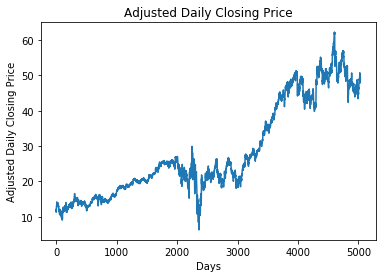

In [33]:
# Plotting Adjusted Daily Closing Price with respect to time.
days = list(range(len(df)))
adj_close = df.sort_values(by='timestamp', ascending=True)['adjusted_close'].tolist()

fig, ax = plt.subplots()
ax.plot(days, adj_close)
ax.set_title('Adjusted Daily Closing Price')
ax.set_xlabel('Days')
ax.set_ylabel('Adjusted Daily Closing Price')
plt.show()

It appears that after the company went IPO, the price of the stock climbed for about the first year, then crashed over the period of another year. Afterwards the price continued to fluctuated about an average value for about 5 years, then started slowly climbing again to the current price. There doesn't seem to be anything unusual about this behavior in my opinion.

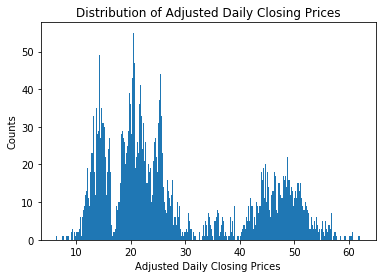

In [34]:
# Plotting the distribution of Adjusted Daily Closing Prices
fig, ax = plt.subplots()
ax.hist(df['adjusted_close'].tolist(), bins=500)
ax.set_title('Distribution of Adjusted Daily Closing Prices')
ax.set_xlabel('Adjusted Daily Closing Prices')
ax.set_ylabel('Counts')
plt.show()

The distribution of Adjusted Daily Closing Prices looks like it could be log-normal which is the distribution type that prices should approximately follow.

In [35]:
# Calculating the log adjusted closing prices, and log adjusted daily returns
df['log_adj_close'] = np.log(df['adjusted_close'])
df['log_adj_daily_returns'] = df['log_adj_close'].shift(1) - df['log_adj_close']
df.dropna(subset=['log_adj_daily_returns'], inplace=True)

We are calculating the log of Adjusted Daily Closing Price as well as the difference between the logs of Adjusted Daily Closing Price because if Adjusted Daily Closing Price is log-normal distributed, then the distributions of these values should be normally distributed. This is because the log of a log-normally distributed variable should be normally distributed, and the sum (or difference) of independently normally distributed variables should also be normally distributed. (We are assuming each Adjusted Daily Closing Price is independently distributed from others, which is approximately true.)

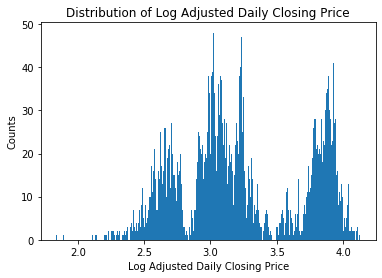

In [36]:
# Plotting the distribution of Log Adjusted Daily Closing Price
fig, ax = plt.subplots()
ax.hist(df['log_adj_close'].tolist(), bins=500)
ax.set_title('Distribution of Log Adjusted Daily Closing Price')
ax.set_xlabel('Log Adjusted Daily Closing Price')
ax.set_ylabel('Counts')
plt.show()

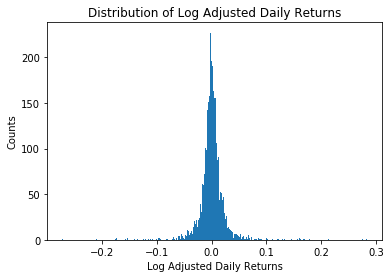

In [37]:
# Plotting the distribution of Log Adjusted Daily Returns
fig, ax = plt.subplots()
ax.hist(df['log_adj_daily_returns'].tolist(), bins=500)
ax.set_title('Distribution of Log Adjusted Daily Returns')
ax.set_xlabel('Log Adjusted Daily Returns')
ax.set_ylabel('Counts')
plt.show()

Although the distribution of log Adjusted Daily Closing Price doesn't appear to be too normal, the distribution of Log Adjusted Daily Returns appears to visually fit a normal distribution well. Therefore we are probably safe in make our assumptions about log-normal prices, and independently distributed prices.

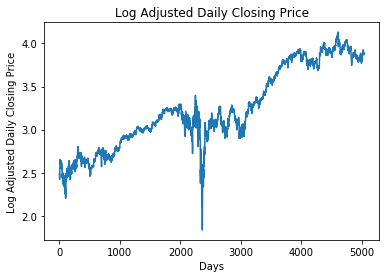

In [38]:
# Plotting Adjusted Daily Returns with respect to time
days = list(range(len(df)))
log_adj_close = df.sort_values(by='timestamp', ascending=True)['log_adj_close'].tolist()

fig, ax = plt.subplots()
ax.plot(days, log_adj_close)
ax.set_title('Log Adjusted Daily Closing Price')
ax.set_xlabel('Days')
ax.set_ylabel('Log Adjusted Daily Closing Price')
plt.show()

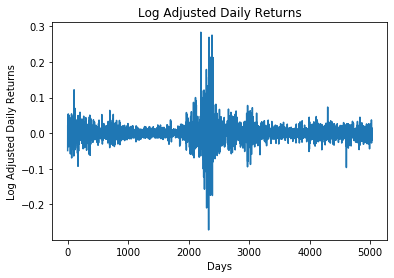

In [39]:
# Plotting Adjusted Daily Returns with respect to time
days = list(range(len(df)))
log_adj_daily_returns = df.sort_values(by='timestamp', ascending=True)['log_adj_daily_returns'].tolist()

fig, ax = plt.subplots()
ax.plot(days, log_adj_daily_returns)
ax.set_title('Log Adjusted Daily Returns')
ax.set_xlabel('Days')
ax.set_ylabel('Log Adjusted Daily Returns')
plt.show()

The time series of log Adjusted Daily Closing Price appears similar to the time series of Adjusted Daily Closing Price. This is as expected and not unusual because we are just taking a log a variable and thus the overall shape of the graph should not be affected. On the other hand the time series of log Adjusted Daily Returns appears to fluctuate about zero where the magnitude of the fluctuation does not change too much except for at a few pivitol days. This makes sense with respect to its Gaussian distribution, because the Gaussian distribution alots small probabilities to large magnitudes of log Adjusted Daily Return which means there should not be too many days where we see a huge value for log Adjusted Daily Return.

### Text Data

The first thing we will check are the lengths of our raw documents.

In [75]:
# Constructing doc_lengths: a list of lengths of all 8-K forms before they are normalized
doc_lengths_paths_dict = {}

for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        doc_lengths_paths_dict[len(raw_doc_text)] = doc_path

In [41]:
print("Largest document has: {} charcters".format(max(doc_lengths_paths_dict.keys())))
print("Smallest document has: {} charcters".format(min(doc_lengths_paths_dict.keys())))
largest_doc_path = doc_lengths_paths_dict[max(doc_lengths_paths_dict.keys())]
smallest_doc_path = doc_lengths_paths_dict[min(doc_lengths_paths_dict.keys())]

Largest document has: 125997383 charcters
Smallest document has: 3548 charcters


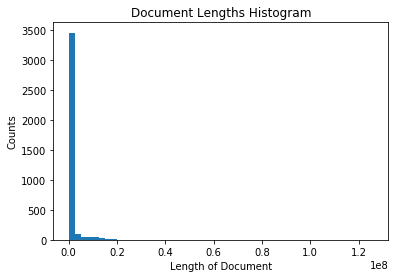

In [42]:
fig, ax = plt.subplots()
ax.hist(doc_lengths_paths_dict.keys(), bins=50)
ax.set_title('Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

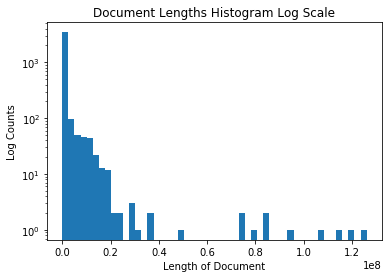

In [43]:
fig, ax = plt.subplots()
ax.hist(doc_lengths_paths_dict.keys(), bins=50, log=True)
ax.set_title('Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

From the above histograms, it appears very few of our documents contain over 30 million characters. Most of our documents seem to have 10 million characters or less with a large emphasize on documents with less than 1 million characters. Since a single characters is about 1 byte in memory, our largest document should be about 125 MB. Therefore we should expect all of our documents to be able to fit into our RAM of 32 GB

#### Text Preprocessing

To preprocess our text data, we will first strip it of its x/html tags if the data is encoded this way. Next we will un accent its accented characters, lower case the entire document, and replace all newline/carriage returns with spaces. Next we will strip it of its characters that are not alphanumeric, periods, dollar symbols, or percent symbols. Afterwards we will reduce all words to their dictionary lemmas, and strip the document of its stop words (see stop word list for spacy en_cor_web_sm model). Finally we will replace all whitespace characters with regular space characters.

The structure of our 8-K filing document involves an xml SEC document header packed with metadata about the filing, and one or multiple xml `<DOCUMENT>` tags. These `<DOCUMENT>` tags contain different types of data that are bundled up into the complete submission for the 8-K filing. The data types stored in these `<DOCUMENT>` tags can range from everything including: regular text data such as html, to binary blob data such as jpg images and pdfs. The structure of these `<DOCUMENT>` tags involve a few meta data tags, none of which involve specifying the encoding type of the data that `<DOCUMENT>` tag stores, and a `<TEXT>` tag that stores the actual data.

Since the inclusion of binary blobs in the markdown prevents easy parsing of the filing structure with lxml, we will result to python re statements to extract the relevant `<DOCUMENT>` tags. Though because the meta data tags enclosed in a `<DOCUMENT>` tag do not specify the encoding type of the data enclosed in the `<TEXT>` tag, there does not appear to be an easy quick general solution that extracts the text data `<DOCUMENT>` tags and avoids the binary blob like `<DOCUMENT>` tags. Because of the above issues we will have to suffice ourselves with extracting only the `<DOCUMENT>` tag that contain's the meta data open tag `<TYPE>8-K`. This specific `<DOCUMENT>` tag always contains text data, and represents the data that is used to generate the SEC 8-K form containing the information that is mandated by the SEC, and excluding the exhibit information that is not mandated by the SEC and is given by the company's discretion. Since this `<DOCUMENT>` tag contains all the mandated information by the SEC for a given 8-K filing, we are still extracting the important information bundled in the filing even though we are not extracting all of the textual information.

In [255]:
# Importing Libraries

import re
import lxml
import unicodedata
import en_core_web_sm
from bs4 import BeautifulSoup

nlp = en_core_web_sm.load(disable=['parser', 'ner'])
#nlp.max_length = 400000000

def extract_8k(doc):
    eight_k = re.findall('<DOCUMENT>\n<TYPE>8-K.*?<SEQUENCE>1(.*?)</DOCUMENT>', doc, re.DOTALL | re.IGNORECASE)
    text = re.findall('<TEXT>(.*?)</TEXT>', eight_k[0], re.DOTALL | re.IGNORECASE)
    return text

def extract_html(doc):
    html = re.findall('<HTML(?:>| .*?>).*?</HTML>', doc, re.DOTALL | re.IGNORECASE)
    return html

def strip_tags(doc):
    # extracting 8-K <DOCUMENT> tag from the filing
    eight_k = extract_8k(doc)
    assert len(eight_k) == 1, 'Check re for 8-K extraction, either multiple 8-K DOCUMENT tags or bad re'
    
    # extracting <html> tag if any
    html = extract_html(eight_k[0])
    assert 0 <= len(html) <= 1, 'Check re for extracting html tags'
    
    # if html exists
    if len(html) == 1:
        html = html[0]
        soup = BeautifulSoup(html, 'lxml')
        stripped = soup.get_text()
    else:
        soup = BeautifulSoup(eight_k[0], 'lxml')
        stripped = soup.get_text()
    
    return stripped

def strip_accented_chars(doc):
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return doc

def strip_special_chars(doc):
    doc = re.sub('[^$A-Za-z0-9%\s.\']', '', doc)
    return doc

def lemmatize(doc):
    document = nlp(doc)
    doc = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in document])
    return doc

def strip_stop_words(doc):
    document = nlp(doc)
    doc = ' '.join([word.text for word in document if not word.is_stop])
    return doc

def strip_large_words(doc, cut_off=20):
    return ' '.join([word for word in doc.split() if len(word) < cut_off])

def normalize_document(doc, tags_strip=True, accent_char_strip=True, lower_case=True,
                       no_newlines=True, special_char_strip=True, space_nums=True,
                       lemmatize_words=True, remove_stop_words=True, strip_extra_spaces=True,
                       remove_large_words=True, debug=False):
    '''
    Preprocesses the document :param doc: and returns the normalized document.
    
    :param doc: string, document to normalize
    :param xml_strip: bool, set to True to strip the xml tags
    :param accent_char_strip: bool, set to True to replace accented characters with their non accented versions
    :param lower_case: bool, set to True to lower case the document.
    :param no_newlines: bool, set to True to remove all newlines characters and replace them with spaces
    :param special_char_strip: bool, set to True to remove all characters that are 
                                     not letters, numbers, $, ., %, or spaces
    :param lemmatize_words: bool, set to True to map each word to its lemma
    :param remove_stop_words: bool, set to True to remove stop words
    :param strip_extra_spaces: bool, set to True to replace multiple spaces with one
    :param remove_large_words: bool, set to True to remove large words equal to or above 20 characters in length
    
    ---> string, normalized document
    '''
    if debug:
        print('raw length of doc: {}'.format(len(doc)))
        
    # stripping tags
    if tags_strip:
        doc = strip_tags(doc)
    if debug:
        print('stripped tag length: {}'.format(len(doc)))
    
    # stripping accented characters
    if accent_char_strip:
        doc = strip_accented_chars(doc)
    if debug:
        print('altered accents length: {}'.format(len(doc)))
        
    # lower casing the document
    if lower_case:
        doc = doc.lower()
    if debug:
        print('lower casing length: {}'.format(len(doc)))
    
    # removing new lines and carriage returns and replacing them with spaces
    if no_newlines:
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
    if debug:
        print('removing newlines length: {}'.format(len(doc)))
    
    # removing special characters
    if special_char_strip:
        doc = strip_special_chars(doc)
    if debug:
        print('strip special char length: {}'.format(len(doc)))
    
    # lemmatizing the words
    if lemmatize_words:
        doc = lemmatize(doc)
    if debug:
        print('lemmatized doc length: {}'.format(len(doc)))
    
    # stripping stop words
    if remove_stop_words:
        doc = strip_stop_words(doc)
    if debug:
        print('removed stop word length: {}'.format(len(doc)))
    
    # adding spaces in between numbers and remaining special characters
    if space_nums:
        doc = re.sub(r'([\d$%.])', r' \1 ', doc)
    if debug:
        print('spaced num char length: {}'.format(len(doc)))
        
    # Removing large words
    if remove_large_words:
        doc = strip_large_words(doc)
    if debug:
        print('large words removed char length: {}'.format(len(doc)))
        
    # removing extra whitespace
    if strip_extra_spaces:
        doc = re.sub(' +', ' ', doc)
    if debug:
        print('removed extra space length: {}'.format(len(doc)))
    
    return doc

def normalize_save_document(link, endpoint):
    '''
    Normalize, and save normalized document located at link. The normalized document is saved at location endpoint.
    Returns a path to the saved normalized document.
    
    :param link: string, path to document to be normalized
    :param endpoint: string, path to location to save normalized document
    
    ---> string, path to saved normalized document
    '''
    doc_name = os.path.split(link)[-1]
    
    if not os.path.isdir(endpoint):
        os.mkdir(endpoint)
    
    with open(link, 'r') as file:
        raw_document = file.read()
        
    norm_doc = normalize_document(raw_document)
    
    with open(os.path.join(endpoint, doc_name), 'w') as normalized_file:
        normalized_file.write(norm_doc)
        
    return os.path.join(endpoint, doc_name)

The first thing we will need to confirm is if the re's we constructed for extracting a documents 8-K component, and the html tag (if they exist) works/still works. For the time being the data we will use from each document will only be the text embedded in the 8-K component of the document.

In [256]:
# Checking the extract_8k function
checksout = True
for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        num_of_8k = len(extract_8k(raw_doc_text))
        if num_of_8k != 1:
            checksout = False
            print('Filing: {0}, contains: {1} 8-K portions, check re of extract_8k, and document.'.format(doc_path, num_of_8k))

if checksout:
    print('The re in extract_8k seems to checkout.')

The re in extract_8k seems to checkout.


In [257]:
# Checking the extract_html function
checksout = True
for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        eight_k = extract_8k(raw_doc_text)[0]
        num_html_tags = len(extract_html(eight_k))
        if not (0 <= num_html_tags <= 1):
            checksout = False
            print('Filing: {0}, contains: {1} html tags, check re of extract_html, and document.'.format(doc_path, num_html_tags))

if checksout:
    print('The re in extract_html seems to checkout.')

The re in extract_html seems to checkout.


In each 8-K filing there should be only one `<DOCUMENT>...</DOCUMENT>` tag that contains a:`<TYPE>8-K` tag. There should also be ONLY one `<html ...>...</html>` tag if the document tag contains an html tag. The above cells verify if any of these conditions are violated on the current dataset.

The next thing we will investigate are the lengths of our normalized texts.

In [258]:
# Constructing norm_doc_lengths: a list of lengths of Intel's 8-K forms after they are normalized
norm_doc_lengths_paths_dict = {}

for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')    
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        norm_doc = normalize_document(raw_doc_text)
        norm_doc_lengths_paths_dict[len(norm_doc)] = doc_path

In [259]:
print("Largest document has: {} charcters".format(max(norm_doc_lengths_paths_dict.keys())))
print("Smallest document has: {} charcters".format(min(norm_doc_lengths_paths_dict.keys())))
largest_norm_doc_path = norm_doc_lengths_paths_dict[max(norm_doc_lengths_paths_dict.keys())]
smallest_norm_doc_path = norm_doc_lengths_paths_dict[min(norm_doc_lengths_paths_dict.keys())]

Largest document has: 606295 charcters
Smallest document has: 946 charcters


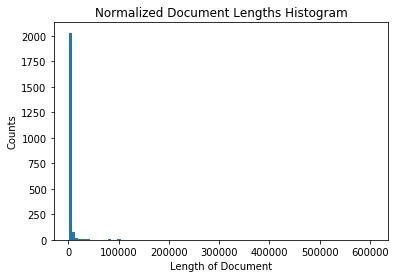

In [260]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths_paths_dict.keys(), bins=100)
ax.set_title('Normalized Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

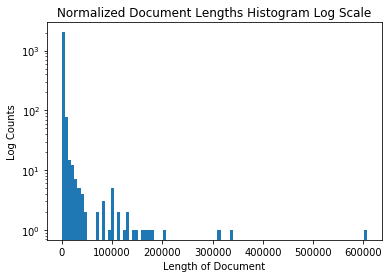

In [261]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths_paths_dict.keys(), bins=100, log=True)
ax.set_title('Normalized Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

Nothing seems to stand out in these histograms so far. The next things we will check are the documents that correspond to the extremums of our histograms just to see if anything stands out about these normalized documents.

In [262]:
# Checking Largest Normalized Document
with open(largest_norm_doc_path) as f:
    largest_norm_doc_raw = f.read()

largest_norm_doc = normalize_document(largest_norm_doc_raw, debug=True)
print()
print(largest_norm_doc_path)
print()
print(largest_norm_doc)

raw length of doc: 78927377
stripped tag length: 731646
altered accents length: 728747
lower casing length: 728747
removing newlines length: 728742
strip special char length: 705357
lemmatized doc length: 686438
removed stop word length: 559678
spaced num char length: 708948
large words removed char length: 606295
removed extra space length: 606295

/media/Data/Programs/FinTech/data/documents/JPM/0000019617-11-000266.txt

exhibit 9 9 2 q 1 1 1 0 q item 1 2 exhibit 9 9 jpmorgan chase co . consolidate financial highlight unaudite million share headcount ratio datum month end june 3 0 as period end 2 q 1 1 1 q 1 1 4 q 1 0 3 q 1 0 2 q 1 0 2 0 1 1 2 0 1 0 selected income statement datum total net revenue $ 2 6 7 7 9 $ 2 5 2 2 1 $ 2 6 0 9 8 $ 2 3 8 2 4 $ 2 5 1 0 1 $ 5 2 0 0 0 $ 5 2 7 7 2 total noninter expense 1 6 8 4 2 1 5 9 9 5 1 6 0 4 3 1 4 3 9 8 1 4 6 3 1 3 2 8 3 7 3 0 7 5 5 preprovision profita 9 9 3 7 9 2 2 6 1 0 0 5 5 9 4 2 6 1 0 4 7 0 1 9 1 6 3 2 2 0 1 7 provision credit loss 1 8 1 0

In [263]:
# Checking Smallest Normalized Document
with open(smallest_norm_doc_path, 'r') as f:
    smallest_norm_doc_raw = f.read()

smallest_norm_doc = normalize_document(smallest_norm_doc_raw, debug=True)
print()
print(smallest_norm_doc_path)
print()
print(smallest_norm_doc)

raw length of doc: 4158
stripped tag length: 2312
altered accents length: 2312
lower casing length: 2312
removing newlines length: 2289
strip special char length: 1876
lemmatized doc length: 1897
removed stop word length: 1765
spaced num char length: 1937
large words removed char length: 946
removed extra space length: 946

/media/Data/Programs/FinTech/data/documents/C/0000950123-02-007241.txt

u . s . security exchange commission washington d . c . 2 0 5 4 9 form 8 k current report pursuant section 1 3 1 5 d security exchange act 1 9 3 4 date report date early event report july 2 5 2 0 0 2 citigroup inc . exact registrant specify charter delaware 1 9 9 2 4 5 2 1 5 6 8 0 9 9 state commission irs employer jurisdiction file number identification . incorporation 3 9 9 park avenue new york new york 1 0 0 4 3 address principal executive office zip code 2 1 2 5 5 9 1 0 0 0 registrant telephone number include area code citigroup inc . current report form 8 k item 5 . event . july 2 5 2 0 0 2 

Nothing seems out of the ordinary about these two normalized documents. The relevant information of the 8-K Document sections of the 8-K filings are still there. The Item #.## sections are still existant in these normalized documents, thus they still contain the information that will be important for analysis, albiet with some noise still

#### Vocab and Word Frequency Analysis

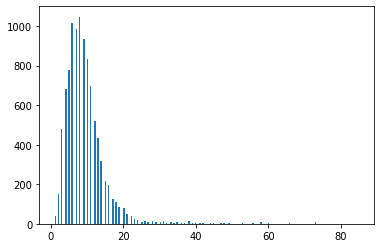

In [235]:
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

word_lens = list(map(len, vocab.keys()))
fig, ax = plt.subplots()
ax.hist(word_lens, bins=200)
plt.show()

In [254]:
cut_off = 20
words_greater_than = [word for word in vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['wfccommonstockparvalue', 'noncumulativeperpetualconvertibleclasspreferredstockserieslmember', 'wfcdepositaryshareseachrepresenting', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesnmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesomember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriespmember', 'fixedtofloatingratenoncumulativeperpetualclasspreferredstockseriesqmember', 'fixedtofloatingratenoncumulativeperpetualclasspreferredstockseriesrmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriestmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesvmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockserieswmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesxmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesymember', 'fixedtofloatingratenormalwachoviaincometrustsecuritiesofwachoviacapitaltrustiiimember', 'wfcgu

### Conclusion

From our exploratory analysis we can conclude that our pricing data seems to fit the assumptions one usually assumes about stock pricing data. This means that the stock pricing data should be distributed log-normally and implies that the log returns of a stock over a period of time should be distributed normally. Our exploratory analysis of our text data shows there is nothing unusual about our raw text data, and it should fit into memory fine. It also shows that our text preprocessing methods still preserve the important parts of our text data and thus should not pose a future issue for analysis. From these findings we can conclude that our raw text data is useable, our text preprocessing methods are useable, and our price data is useable. Since the log returns of our pricing data (Adjusted Daily Closing Price) appear to fit a Gaussian distribution pretty well, our predictor variable in analysis should be log returns (as opposed to Adjusted Daily Closing Price) because the Gaussian distribution has some nice mathematical properties that might be leveraged further on in the future.

## Modeling

In [2]:


import os
import json
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#tf.enable_eager_execution()

gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))

if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


### Data Preprocessing

In [3]:
# Post Mortem Preprocessing

'''
Since the raw_df was originally shaped incorrectly, and the raw documents have not been normalized yet, before
preprocessing we need to reshape the DataFrame and normalize all the raw documents.
'''

raw_df = pd.read_csv(os.path.join(path_to_data, 'raw_' + ticker + '.csv'), parse_dates=['timestamp'])
raw_df.info()
raw_df.head()

NameError: name 'path_to_data' is not defined

In [4]:
# Functions for post mortem preprocessing

def build_vocab(document, file_path):
    '''
    Adds to the already existing vocabulary file found at :param file_path: the new vocabulary found in the 
    normalized document :param document:.

    :param document: string, normalized document to calculate vocabulary from.
    :param file_path: string, path to vocabulary json file
    
    ---> :param file_path:
    might need to add padding character since normed docs do not contain padded char
    '''
    
    # Loading already established vocabulary
    try:
        with open(file_path, 'r') as f:
            vocab = json.load(f)
            
    except FileNotFoundError:
        vocab  = {}
        
    # Updating vocabulary dictionary
    if not vocab:
        last_word_encoding = 0
    else:
        last_word_encoding = max(vocab.values())
    
    for word in document.split():
        # if a word in the document is not in the current vocab, add it with a word encoding value larger than the largest word encoding value
        if word not in vocab:
            vocab[word] = last_word_encoding + 1
            last_word_encoding = last_word_encoding + 1
            
    with open(file_path, 'w') as f:
        json.dump(vocab, f)
    
    return 

def reshape(raw_df):
    '''
    Reshaping raw_df to add columns for each stock ticker
    '''
    
    # filling na values in doc col of raw_docs
    raw_df['doc'].fillna(json.dumps([]), inplace=True)
    
    # Creating new empty columns
    for t in tickers:
        raw_df['_'.join(['docs', t])] = json.dumps([])
    
    # Populating empty columns with doc links
    for i in raw_df.index:
        doclist = json.loads(raw_df.iloc[i, raw_df.columns.get_loc('doc')])
        for doc in doclist:
            link = doc['link']
            t = doc['ticker']
            doclist_for_t = json.loads(raw_df.at[i, '_'.join(['docs', t])])
            doclist_for_t.append(link)
            raw_df.at[i, '_'.join(['docs', t])] = json.dumps(doclist_for_t)
    
    # Dropping redundant doc column
    raw_df.drop(['doc'], axis=1, inplace=True)
    
    return raw_df

def preprocess_pm(raw_df):
    '''
    Preprocessing raw_df into the shape raw_df should have been after coming out of the fetch process, as well as 
    normalizing the documents.
    '''
    
    # Reshaping DataFrame
    reshaped_df = reshape(raw_df)
    
    # Normalizing and updating documents    
    def update_doclist(s):
        doclist = json.loads(s)
        updated_doclist = []
        for docpath in doclist:
            save_point = os.path.join(os.path.split(docpath)[0], 'normalized')
            norm_docpath = normalize_save_document(docpath, save_point)
            updated_doclist.append(norm_docpath)
            
        return json.dumps(updated_doclist)
    
    for t in tickers:
        reshaped_df['_'.join(['docs', t])] = reshaped_df['_'.join(['docs', t])].map(update_doclist)
        
    # Preprocessing numerical data
    reshaped_df['log_adj_close'] = np.log(reshaped_df['adjusted_close'])
    reshaped_df['log_adj_daily_returns'] = reshaped_df['log_adj_close'] - reshaped_df['log_adj_close'].shift(-1)
    reshaped_df.dropna(subset=['log_adj_daily_returns'], inplace=True)
    
    # Building vocabulary json file
    path_to_vocab = os.path.join(path_to_data, 'vocab.json')
    
    def vocab_from_doclist(s):
        doclist = json.loads(s)
        
        for docpath in doclist:
            with open(docpath, 'r') as f:
                doc = f.read()
            
            build_vocab(doc, path_to_vocab)
        
        return json.dumps(doclist)
    
    for t in tickers:
        reshaped_df['_'.join(['docs', t])].map(vocab_from_doclist)
        
    # Encoding documents based off of vocabulary json file
    
    
    return reshaped_df

In [5]:
raw_df_fixed = preprocess_pm(raw_df)
raw_df_fixed.to_csv(os.path.join(path_to_data, 'raw_' + ticker + '_fixed' + '.csv'), index=False)

NameError: name 'normalize_save_document' is not defined

In [3]:
raw_df_fixed = pd.read_csv(os.path.join(path_to_data, 'raw_' + ticker + '_fixed' + '.csv'), parse_dates=['timestamp'])
raw_df_fixed.info()
raw_df_fixed.head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032 entries, 0 to 5031
Data columns (total 15 columns):
timestamp                5032 non-null datetime64[ns]
open                     5032 non-null float64
high                     5032 non-null float64
low                      5032 non-null float64
close                    5032 non-null float64
adjusted_close           5032 non-null float64
volume                   5032 non-null float64
dividend_amount          5032 non-null float64
split_coefficient        5032 non-null float64
docs_WFC                 5032 non-null object
docs_JPM                 5032 non-null object
docs_BAC                 5032 non-null object
docs_C                   5032 non-null object
log_adj_close            5032 non-null float64
log_adj_daily_returns    5032 non-null float64
dtypes: datetime64[ns](1), float64(10), object(4)
memory usage: 589.8+ KB


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,docs_WFC,docs_JPM,docs_BAC,docs_C,log_adj_close,log_adj_daily_returns
0,2019-10-11,49.46,49.92,49.15,49.21,49.21,22763506.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[],3.896097,0.011445
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,[],[],[],[],3.884652,0.010331
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,[],[],[],[],3.874321,0.006877
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[],3.867444,-0.020491
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900.0,0.0,1.0,[],[],[],[],3.887935,-0.008162
5,2019-10-04,48.66,49.25,48.53,49.21,49.21,15779500.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[],3.896097,0.014946
6,2019-10-03,48.30,48.51,47.32,48.48,48.48,20212200.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[],3.881151,0.000206


In [4]:
raw_df_fixed.tail()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,docs_WFC,docs_JPM,docs_BAC,docs_C,log_adj_close,log_adj_daily_returns
5027,1999-10-19,20.2500,21.000,20.1884,20.813,12.0448,10397000.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],"[""/media/Data/Programs/FinTech/data/documents/...",2.488633,0.052400
5028,1999-10-18,19.4690,19.844,19.2507,19.750,11.4299,5041000.0,0.0,1.0,[],[],[],[],2.436233,0.012732
5029,1999-10-15,19.3749,19.938,19.2190,19.500,11.2853,7528400.0,0.0,1.0,[],[],[],[],2.423501,-0.039279
5030,1999-10-14,19.8133,20.406,19.7810,20.281,11.7374,6496800.0,0.0,1.0,[],[],[],[],2.462780,0.021808
5031,1999-10-13,20.7190,20.938,19.4690,19.844,11.4842,4730400.0,0.0,1.0,[],[],[],[],2.440972,-0.049162


In [5]:
# Writing tfrecords

feature_names = ['log_adj_daily_returns', 'docs_WFC', 'docs_JPM', 'docs_C', 'docs_BAC']
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)


# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    '''Returns a bytes_list from a string / byte.'''
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    '''Returns a float_list from a float / double.'''
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    '''Returns an int64_list from a bool / enum / int / uint.'''
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(sample, feature_names):
    
    feature = {}
    
    for feature_name in feature_names:
        # if feature is a number 
        if isinstance(sample[feature_name], float):
            feature[feature_name] = tf.train.Feature(float_list=tf.train.FloatList(value=[sample[feature_name]]))
        
        # if feature is a doclist
        elif isinstance(sample[feature_name], list):
            lens = list(map(len, sample[feature_name]))
            values = [word for doc in sample[feature_name] for word in doc]
            feature[feature_name + '/vals'] = tf.train.Feature(int64_list=tf.train.Int64List(value=values))
            feature[feature_name + '/lens'] = tf.train.Feature(int64_list=tf.train.Int64List(value=lens))

    return tf.train.Example(features=tf.train.Features(feature=feature))
        


def unpack_doclist(doclist_string):        
    def load_encode_file(filename):
        with open(filename, 'r') as f:
            text = f.read()
        return [vocab[word] for word in text.split()]
    return list(map(load_encode_file, json.loads(doclist_string)))


record_file = 'test.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for i in range(300, -1, -1):
        row = raw_df_fixed.iloc[i].copy(deep=True)
        # Unpacking Text Features
        row[['_'.join(['docs', t]) for t in tickers]] = row[['_'.join(['docs', t]) for t in tickers]].map(unpack_doclist)
        # Serializing Example to disk
        example = serialize_example(row, feature_names)
        writer.write(example.SerializeToString())
    


In [9]:
# Loading and parsing TFRecords Dataset

raw_dataset = tf.data.TFRecordDataset('test.tfrecords')

def parse_example(example_proto):
    
    # Create a dictionary describing the features.
    feature_description = {
        'log_adj_daily_returns': tf.io.FixedLenFeature([], tf.float32),
        'docs_WFC/vals': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_WFC/lens': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_JPM/vals': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_JPM/lens': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_BAC/vals': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_BAC/lens': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_C/vals': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_C/lens': tf.io.VarLenFeature(dtype=tf.int64)    
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Reconstructing Ragged Tensors from Example
    example['docs_WFC'] = tf.RaggedTensor.from_row_lengths(example['docs_WFC/vals'].values,
                                                           row_lengths=example['docs_WFC/lens'].values)
    example['docs_JPM'] = tf.RaggedTensor.from_row_lengths(example['docs_JPM/vals'].values,
                                                           row_lengths=example['docs_JPM/lens'].values)
    example['docs_BAC'] = tf.RaggedTensor.from_row_lengths(example['docs_BAC/vals'].values,
                                                           row_lengths=example['docs_BAC/lens'].values)
    example['docs_C'] = tf.RaggedTensor.from_row_lengths(example['docs_C/vals'].values,
                                                           row_lengths=example['docs_C/lens'].values)
    
    # Deleting Redundant Keys
    del example['docs_WFC/vals']
    del example['docs_WFC/lens']
    
    del example['docs_JPM/vals']
    del example['docs_JPM/lens']
    
    del example['docs_BAC/vals']
    del example['docs_BAC/lens']
    
    del example['docs_C/vals']
    del example['docs_C/lens']
      
    return example

parsed_dataset = raw_dataset.map(parse_example)


In [7]:
# Preprocessing dataset to time series


def parse_example(example_proto):
    
    # Create a dictionary describing the features.
    feature_description = {
        'log_adj_daily_returns': tf.io.FixedLenFeature([], tf.float32),
        'docs_WFC/vals': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_WFC/lens': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_JPM/vals': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_JPM/lens': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_BAC/vals': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_BAC/lens': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_C/vals': tf.io.VarLenFeature(dtype=tf.int64),
        'docs_C/lens': tf.io.VarLenFeature(dtype=tf.int64)    
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Reconstructing Ragged Tensors from Example
    example['docs_WFC'] = tf.RaggedTensor.from_row_lengths(example['docs_WFC/vals'].values,
                                                           row_lengths=example['docs_WFC/lens'].values)
    example['docs_JPM'] = tf.RaggedTensor.from_row_lengths(example['docs_JPM/vals'].values,
                                                           row_lengths=example['docs_JPM/lens'].values)
    example['docs_BAC'] = tf.RaggedTensor.from_row_lengths(example['docs_BAC/vals'].values,
                                                           row_lengths=example['docs_BAC/lens'].values)
    example['docs_C'] = tf.RaggedTensor.from_row_lengths(example['docs_C/vals'].values,
                                                           row_lengths=example['docs_C/lens'].values)
    
    # Deleting Redundant Keys
    del example['docs_WFC/vals']
    del example['docs_WFC/lens']
    
    del example['docs_JPM/vals']
    del example['docs_JPM/lens']
    
    del example['docs_BAC/vals']
    del example['docs_BAC/lens']
    
    del example['docs_C/vals']
    del example['docs_C/lens']
      
    return example

def make_window_dataset(ds, window_size, shift=1, stride=1):
    
    windows = ds.window(window_size, shift=shift, stride=stride)
    
    feature_datasets = {key: windows.flat_map(lambda x: x[key].batch(window_size, drop_remainder=True))
                        for key in windows.element_spec.keys()}
    
    return tf.data.Dataset.zip(feature_datasets)

def extract_labels(timeslice, label_feature):
    label = None
    
    for feature_key in timeslice.keys():
        feature_timeslice = timeslice[feature_key]
        if feature_key == label_feature:
            label = feature_timeslice[-1]
        timeslice[feature_key] = feature_timeslice[:-1]
        
    return (timeslice, label)


def to_time_series(ds, label_feature, window_size=5, steps_to_pred=1, num_of_preds=1):
    
    # making full time series Dataset object (features + labels)
    full_ts_ds = make_window_dataset(ds, window_size=window_size+1)
    
    # mapping dataset to Dataset where each el is: (features: dict, labels)
    ts_ds = full_ts_ds.map(lambda s: extract_labels(s, label_feature))
    
    return ts_ds

def sample_documents(sample):
    # Extracting all documents in the sample
    docs_in_sample = sample.values
    # Sampling a random document from all the documents in the sample
    if docs_in_sample.nrows() != 0:
        i = tf.random.uniform([1], maxval=docs_in_sample.nrows(), dtype=tf.int64)[0]
        sample_doc = docs_in_sample[i]
    else:
        sample_doc = tf.constant([], dtype=tf.int64)
        
    return sample_doc

def mapfunc(features, labels):
    
    for fname in features.keys():
        feature = features[fname]
        timesteps = feature.shape[0]
        # Feature is a doc feature
        if isinstance(feature, tf.RaggedTensor):
            doc = sample_documents(feature)
            feature = tf.stack([doc for day in range(timesteps)])
            features[fname] = feature
        
    return (features, labels)

def filter_fn(f, l):
    shape = tf.shape(f['docs_WFC'])[1]
    return tf.math.not_equal(shape, 0)


raw_dataset = tf.data.TFRecordDataset('test.tfrecords')
parsed_dataset = raw_dataset.map(parse_example)
tsds = to_time_series(parsed_dataset, 'log_adj_daily_returns')


# Converts to one doc per window time series
tsds = tsds.map(mapfunc)
tsds = tsds.filter(filter_fn)

for el in tsds:
    print(el[0]['docs_WFC'].shape)
    print()

(5, 554)

(5, 503)

(5, 485)

(5, 528)

(5, 503)

(5, 512)

(5, 512)

(5, 512)

(5, 490)

(5, 490)

(5, 476)

(5, 516)

(5, 516)

(5, 519)

(5, 516)

(5, 490)

(5, 519)

(5, 680)

(5, 514)

(5, 490)

(5, 680)

(5, 633)

(5, 633)

(5, 621)

(5, 621)

(5, 633)

(5, 631)

(5, 573)

(5, 573)

(5, 522)

(5, 522)

(5, 573)

(5, 475)

(5, 522)

(5, 719)

(5, 475)

(5, 588)

(5, 475)

(5, 588)

(5, 528)

(5, 594)

(5, 617)

(5, 479)

(5, 594)

(5, 479)

(5, 545)

(5, 545)

(5, 545)

(5, 545)

(5, 545)

(5, 504)

(5, 510)

(5, 510)

(5, 440)

(5, 510)

(5, 510)

(5, 440)

(5, 540)

(5, 498)

(5, 670)

(5, 670)

(5, 550)

(5, 509)

(5, 509)

(5, 525)

(5, 566)

(5, 566)

(5, 525)

(5, 516)

(5, 516)

(5, 516)

(5, 474)

(5, 577)

(5, 577)

(5, 577)

(5, 474)

(5, 490)

(5, 490)

(5, 613)

(5, 613)

(5, 556)

(5, 613)

(5, 661)

(5, 627)

(5, 627)

(5, 487)

(5, 627)

(5, 476)

(5, 476)

(5, 476)

(5, 476)

(5, 571)

(5, 571)

(5, 485)

(5, 547)

(5, 571)

(5, 547)

(5, 547)

(5, 670)

(5, 485)



Epoch 1/3
100/100 [==============================] - 2s 24ms/step - loss: 2.4998e-04
Epoch 2/3
100/100 [==============================] - 2s 23ms/step - loss: 1.4198e-04
Epoch 3/3
100/100 [==============================] - 2s 23ms/step - loss: 2.3119e-04


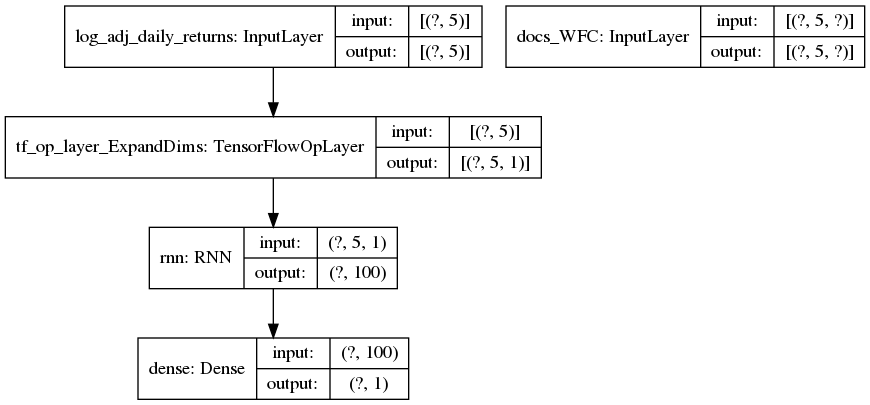

In [9]:
### Modeling
from tensorflow import keras
from tensorflow.keras import layers





# hyperparams
timesteps = 5
batch_size = None
feature_names = ['log_adj_daily_returns', 'docs_WFC', 'docs_JPM', 'docs_C', 'docs_BAC']

# destroying already made graph nodes in the tensorflow backend
tf.keras.backend.clear_session()







def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word, vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix 
            embedding_m = np.zeros((len(vocab) + 1, 300))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)

    return embedding_m

def Word_Embedding(vocab, output_dim=300, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, init='glove', **kwargs):
    
    '''
    Blah blah blah.
    
    :param vocab: string or dict??
    :param init: string,
    
    ---> tf.keras.layers.Embedding, initialized properly.
    '''
    
    if init != None:
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                     weights=[current_embedding_matrix], mask_zero=mask_zero,
                                     input_length=None, **kwargs)
        
    else:
        emb_layer = layers.Embedding(len(vocab) + 1, output_dim=output_dim, 
                                     embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                     activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                     mask_zero=mask_zero, input_length=input_length, **kwargs)
        
    return emb_layer



# document embedding Model

    
with open(os.path.join(path_to_data, 'vocab.json')) as f:
    vocab = json.load(f)
        
#document = keras.Input(shape=(None,), name='document')
#word_embedding = Word_Embedding(vocab, trainable=False)(document)
#document_embedding = layers.LSTM(400)(word_embedding)
#document_embedder = keras.Model(document, document_embedding, name='document_embedder')
#print(document_embedder.summary())

#keras.utils.plot_model(document_embedder, 'document_embedder.png', show_shapes=True)



# Inputs
input_docs_WFC = keras.Input(shape=(timesteps, None), name='docs_WFC')
#input_docs_JPM = keras.Input(shape=(timesteps, None), name='docs_JPM')
#input_docs_BAC = keras.Input(shape=(timesteps, None), name='docs_BAC')
#input_docs_C = keras.Input(shape=(timesteps, None), name='docs_C')
input_log_returns = keras.Input(shape=(timesteps,), name='log_adj_daily_returns')

# Splitting docs_WFC input into its individual timesteps
timesteps_layer = [input_docs_WFC[:, t] for t in range(timesteps)]

# Flattening Documents Dimension for each timestep (cause I don't know how to deal with the extra dimension for the LSTM)
#flattened_timesteps_layer = [tf.reshape(timestep, [-1, tf.reduce_prod(tf.shape(timestep)[1:])]) for timestep in timesteps_layer]

# Word Embedding Layer
word_embedding = Word_Embedding(vocab, init='glove', trainable=True, mask_zero=True)
word_embedding_layer = [word_embedding(timestep) for timestep in timesteps_layer]


# Document Embedding Layer
document_embedding = layers.LSTM(100)
doc_embedding_layer = [document_embedding(timestep) for timestep in word_embedding_layer]

# Preparing Inputs for Time Series
num_features = tf.expand_dims(input_log_returns, -1)
doc_features = tf.stack(doc_embedding_layer, axis=1)
#ts_input = layers.Concatenate()([doc_features, num_features])



# Time Series Component
time_series = layers.RNN(cell=tf.keras.layers.LSTMCell(100))(num_features)

# Output
output = layers.Dense(1)(time_series)

# Creating Model
test_model = keras.Model({'docs_WFC': input_docs_WFC, 'log_adj_daily_returns': input_log_returns}, output, name='test_model')

# Compiling Model
test_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())





# Training Model
test_ds = tsds.batch(1).repeat()


test_model.fit_generator(test_ds, epochs=3, steps_per_epoch=100)
keras.utils.plot_model(test_model, 'test.png', show_shapes=True)


In [7]:
d = tf.data.Dataset.range(10)
d.element_spec.dtype


tf.int64

### Text Embedding

In [ ]:
## topology
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

title_input = keras.Input(shape=(None,), name='title')

keras.utils.plot_model(simple_lstm_model, 'testing.png', show_shapes=True)



#### Word Embedding

We are going to use pretrained word vectors, and the same word embedding layer for all documents, why? Saves time, and a word in one doc should contain the same meaning as a word in another doc, but the meaning of the document as a whole is different between documents. This assumption would only be violated if each doc emerges from a different culture or micro culture and thus the words used by one microculture would contain different meanings than the same word in another micro culture. This should be the case cause I am assuming business language is to most extents hedgemonic at least in the US and because these business are writing to the SEC it should be even more hedgemonic since there is only one entity that needs to decode the documents. Yadayadayada flesh out thoughts more here.

In [ ]:

def word_embedding(vocab, initialize):
    return None
    

fsfgsfgdsfgsfdgs

In [ ]:
print('heello')

## EEEEEEEEEEEEEEEEExaaaaaaaaaaaaaaaamplesssssss

In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals
#import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math

gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3000)])

tf.random.set_seed(13)


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

RuntimeError: Virtual devices cannot be modified after being initialized

In [20]:
df = pd.read_csv(os.path.join(path_to_data, 'raw_WFC.csv'))

In [21]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc
0,2019-10-11,49.46,49.92,49.15,49.21,49.21,22763506.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,NaN
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,NaN
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900.0,0.0,1.0,NaN


In [22]:
# Preprocessing Price Data
df['log_adj_daily_returns'] = np.log(df['adjusted_close'].shift(1)) - np.log(df['adjusted_close'])
df.dropna(subset=['log_adj_daily_returns'], inplace=True)

In [23]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc,log_adj_daily_returns
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,NaN,0.011445
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,NaN,0.010331
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.006877
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900.0,0.0,1.0,NaN,-0.020491
5,2019-10-04,48.66,49.25,48.53,49.21,49.21,15779500.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",-0.008162


In [24]:
df.tail()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc,log_adj_daily_returns
5028,1999-10-18,19.4690,19.844,19.2507,19.750,11.4299,5041000.0,0.0,1.0,NaN,0.052400
5029,1999-10-15,19.3749,19.938,19.2190,19.500,11.2853,7528400.0,0.0,1.0,NaN,0.012732
5030,1999-10-14,19.8133,20.406,19.7810,20.281,11.7374,6496800.0,0.0,1.0,NaN,-0.039279
5031,1999-10-13,20.7190,20.938,19.4690,19.844,11.4842,4730400.0,0.0,1.0,NaN,0.021808
5032,1999-10-12,21.0000,21.000,20.6560,20.844,12.0629,3970600.0,0.0,1.0,NaN,-0.049162


In [25]:
n_trail = 4
n_lead = 1
df = to_time_series(df, ['log_adj_daily_returns'], n_trail=n_trail, n_lead=n_lead)

TypeError: to_time_series() got an unexpected keyword argument 'n_trail'

In [26]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc,log_adj_daily_returns
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,NaN,0.011445
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,NaN,0.010331
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.006877
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900.0,0.0,1.0,NaN,-0.020491
5,2019-10-04,48.66,49.25,48.53,49.21,49.21,15779500.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",-0.008162


In [27]:
df.dropna(inplace=True)

In [28]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc,log_adj_daily_returns
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.006877
5,2019-10-04,48.66,49.25,48.53,49.21,49.21,15779500.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",-0.008162
6,2019-10-03,48.30,48.51,47.32,48.48,48.48,20212200.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.014946
7,2019-10-02,48.72,49.04,48.37,48.47,48.47,23515900.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.000206
9,2019-09-30,50.77,50.85,50.06,50.44,50.44,26897100.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",-0.027740


In [29]:
feature_cols = df.columns[0:(len(df.columns) - 1)]
target_cols = df.columns[-1:]

X = df[feature_cols].values
y = df[target_cols].values


# Randomly sampling our rows of data into training and testing dataset (LSTM's state is reset after stepping through each timestep of a single sampe)
train_split = 0.75

mask = np.random.rand(len(y)) < train_split

X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

# Reshaping X the features to be of dimensions (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], n_trail + 1, 1))
X_test = X_test.reshape((X_test.shape[0], n_trail + 1, 1))

ValueError: cannot reshape array of size 17860 into shape (1786,5,1)

In [30]:
print ('Single window of past history')
print (X_train[0])
print ('\n Target temperature to predict')
print (y_train[0])

Single window of past history
['2019-10-04' 48.66 49.25 48.53 49.21 49.21 15779500.0 0.0 1.0
 '[{"link": "/media/Data/Programs/FinTech/data/documents/WFC/0001387131-19-007434.txt", "ticker": "WFC"}]']

 Target temperature to predict
[-0.00816164]


In [31]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [32]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

TypeError: 48.66 is not a string

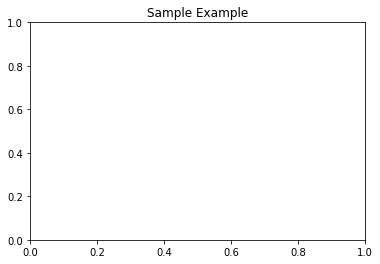

In [33]:
show_plot([X_train[0], y_train[0]], 0, 'Sample Example')

In [34]:
def baseline(history):
    return np.mean(history)

In [35]:
show_plot([X_train[0], y_train[0], baseline(X_train[0])], 0, 'Baseline Prediction Example')

TypeError: can only concatenate str (not "float") to str

In [36]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [42]:
simple_lstm_model = tf.keras.models.Sequential([
    t,
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()

NameError: name 't' is not defined

In [43]:
for x, y in test_dataset.take(1):
    print(simple_lstm_model.predict(x).shape)

NameError: name 'test_dataset' is not defined

In [44]:
EVALUATION_INTERVAL = 200
EPOCHS = 1000

history = simple_lstm_model.fit(train_dataset, epochs=EPOCHS,
                                  steps_per_epoch=EVALUATION_INTERVAL,
                                  validation_data=test_dataset, validation_steps=50)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'simple_lstm_model' is not defined

In [40]:
for x, y in test_dataset.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

NameError: name 'test_dataset' is not defined

In [41]:
# Importing Libraries

import pandas as pd

# Use to prepare dataset as a time series
def to_time_series_prev(df, columns, n_trail=1, n_lead=1):
    '''
    :param df: DataFrame, dataframe object where the columns are the features and labels and the rows are days
    :param columns: list of strings, names of the features and labels (columns of df) to be used in the time series
    :param n_trail: int, number of days behind day 0 that will be used to predict days after day 0
    :param n_lead: int, number of days ahead of day 0 that will be predicted
    
    ---> DataFrame, dataframe object structured like a time series where each row represents an element in the time
                    series, and each column is a feature or label a certain amount of days in the future or past.
    '''
    df = df[columns]
    dfs = []
    col_names = []
    
    # Create trailing columns
    for i in range(n_trail, 0, -1):
        dfs.append(df.shift(-i))
        col_names += [(col_name + '(t-{})'.format(i)) for col_name in columns]
        
    # Create leading columns
    for i in range(0, n_lead+1):
        dfs.append(df.shift(i))
        col_names += [(col_name + '(t+{})'.format(i)) for col_name in columns]
        
    agg = pd.concat(dfs, axis=1)
    agg.columns = col_names
    
    #agg.dropna(inplace=True)
    
    return agg



def to_time_series(df, columns, start_from_t0=1, end_from_t0=1):
    '''
    :param df: DataFrame, dataframe object where the columns are the features and labels and the rows are days
    :param columns: list of strings, names of the features and labels (columns of df) to be used in the time series
    :param n_trail: int, number of days behind day 0 that will be used to predict days after day 0
    :param n_lead: int, number of days ahead of day 0 that will be predicted
    
    ---> DataFrame, dataframe object structured like a time series where each row represents an element in the time
                    series, and each column is a feature or label a certain amount of days in the future or past.
    '''
    df = df[columns]
    dfs = []
    col_names = []
    
    # Create trailing columns
    for i in range(start_from_t0, end_from_t0+1):
        dfs.append(df.shift(i))
        col_names += [(col_name + '(t{})'.format(i)) for col_name in columns]
        
    agg = pd.concat(dfs, axis=1)
    agg.columns = col_names
    
    #agg.dropna(inplace=True)
    
    return agg
    